# **Document Preprocessing**

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from langchain_community.document_loaders import PyMuPDFLoader
import re

def clean_text(text: str) -> str:
    text = re.sub(r"\s+", " ", text)          # collapses newlines/extra spaces
    text = re.sub(r"Page \d+","", text)       # drop footers / headers
    return text.strip()



In [2]:

loader = PyMuPDFLoader("Bangla-Book/HSC26-Bangla1st-Paper.pdf")
raw_docs = loader.load()
len(raw_docs)

49

In [3]:
docs = [d for d in raw_docs if d.page_content.strip()]        # drop blanks
for d in docs:
    d.page_content = clean_text(d.page_content)

In [4]:
len(docs)

49

In [9]:
print(docs[11].page_content)

আমািকেকলাককিকেলতাটিব্সকন্তিসমস্ত ফুকলিভািআমাককর্নকব্দনকর্ি া র্দব্ািিনয নতহই াপর়্ে ার্িল।হাও াআকস, গন্ধপাই, পাতািিব্দশুর্ন— যকব্লআিএকটিমাত্রপা যফলািঅকপক্ষা—এমনসমক যসইএক পদকক্ষকপি দূিত্বটুকুএকমুহকতিঅসীমহই া উঠিল! এতর্দনযেপ্রর্তসন্ধযা আর্মর্ব্নুদাদািব্ার়্েকত র্গ াতঁাহাককঅজিিকর্ি াতুজল ার্িলাম! র্ব্নুদািব্ণিনািভাষাঅতযন্ত সংকীণিব্জল াইতঁািপ্রকতযককথাটি স্ফুজলকঙ্গিমকতাআমািমকনিমাঝখাকনআগুনজ্বাজল ার্দ ার্িল।ব্ুজঝ ার্িলাম যমক টিিরূপব্ক়োআিেি; র্কন্তুনাযদর্খলামতাহাককযচাকখ, নাযদর্খলামতািির্ব্, সমস্তইঅস্পষ্ট্হই াির্হল।ব্ার্হকি যতাযসধিা র্দলইনা, তাহাককমকনওআর্নকতপার্িলামনা—এইিনযমনযসর্দনকািযসইর্ব্ব্াহসভািযদ ালটািব্ার্হকি ভূকতিমকতাদীঘির্নশ্বাসযফজল াযব়্োইকতলার্গল। হর্িকিিকাকিশুর্ন ার্ি, যমক টিককআমািযফাকটাগ্রাফ যদখাকনাহই ার্িল।পিন্দকর্ি াকিব্ই-র্ক।নাকর্িব্ািযতাযকাকনা কািণনাই।আমািমনব্কল, যসির্ব্ তািযকাকনা-একটিব্াকেিমকধযলুকাকনাআকি।একলাঘকিদিিাব্ন্ধকর্ি াএক- একর্দনর্নিালা দুপুিকব্লা যসর্কযসটিখুজল াযদকখনা? েখনঝুঁর্ক াপর়্ে াযদকখতখনির্ব্টিিউপকির্কতািমুকখি দুইধাির্দ াএকলাচুলআর্স াপক়েনা? হঠাৎব্ার্হকিকািওপা

## **Chunking the Documents**

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 700,
    chunk_overlap = 200
)

In [11]:
all_chunks = splitter.split_documents(documents=docs)
len(all_chunks)

167

In [12]:
all_chunks[50].page_content

'নাযেটাতাহাককিা়োই ার্ব্কিষকর্ি াযচাকখপর়্েকতপাকি।যসর্নকিিচার্ির্দককিসককলিযচক অর্ধক- িিনীগন্ধািশুভ্রমঞ্জিীিমকতাসিলব্ৃন্তটিিউপকিদঁা়োই া, যেগাকিফুটি াকিযসগািককযসএককব্াকি অর্তক্রমকর্ি াউঠি াকি।সকঙ্গদুটি-র্তনটিযিাকটাযিাকটাযমক র্িল, তাহার্দগককলই াতাহািহার্সএব্ং কথািআিঅন্তর্িলনা।আর্মহাকতএকখানাব্ইলই াযসর্দকককানপার্ত ািার্খ ার্িলাম।যেটুকুকাকন আর্সকতর্িলযসযতাসমস্তইযিকলমানুষকদিসকঙ্গযিকলমানুর্ষকথা।তাহাির্ব্কিষত্বএইযে, তাহািমকধয ব্ কসিতফাতর্কিুমাত্রর্িলনা- যিাকটাকদিসকঙ্গযসঅনা াকসএব্ংআনকন্দযিাকটাহই ার্গ ার্িল।সকঙ্গ কতকগজলির্ব্ও ালাযিকলকদিগকেিব্ই-তাহািইযকানএকটার্ব্কিষগেযিানাইব্ািিনযযমক িাতাহাকক ধর্ি াপর়্েল।এগের্নি তািার্ব্ি-পঁর্চিব্ািির্ন াকি।যমক কদিযকনযেএতআগ্রহতাহাব্ুজঝলাম।'

## **Embedding Model From HF**

In [13]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [16]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

## **Pinecone Vector DB**

In [17]:
from pinecone import Pinecone
os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

pinecone_api_key = os.getenv("PINECONE_API_KEY")

In [18]:
pc = Pinecone(api_key=pinecone_api_key)

In [19]:
from pinecone import ServerlessSpec ## you are not going to mange the server. and its managed by the cloud provider.
## create index
index_name = "10ms-db-bangla-book"

if not pc.has_index(index_name):
    pc.create_index(
    name=index_name,
    dimension=768,
    metric="dotproduct",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

# **Load the db**

In [20]:
index = pc.Index(index_name)
index

In [22]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)
vector_store

In [23]:
vector_store.add_documents(documents=all_chunks)

['de9b4479-cbb8-4eff-b05c-f5fd30f9fa65',
 '0ac78f03-feaa-4d9c-8af0-0188488255d7',
 '5d6cc80e-a28e-43e5-85c9-18f02a4c5ad9',
 '47bd67a0-7f2f-46e5-8aba-e47abd5f4db8',
 'cac2c045-eb4c-4ba5-8f6f-765b0ae4428d',
 '9a745d63-be42-4966-be71-a8e73b6d4199',
 '768f886c-e795-4c08-8dde-416cf8927fb8',
 '376812a4-d784-434a-8632-7fb912a200ed',
 '73bfba10-640d-48db-8a82-fa140cc7b83b',
 'ee95c7b0-31cc-4e6f-a04b-98fb369f7eb4',
 '1bec009d-4718-41dd-bcb4-d0d3c17b0fd3',
 '51b36ca7-29da-46bd-b68e-0bff4d1f4fc6',
 'f17a2e82-4b91-4f6f-9403-cbfed3aced84',
 '72ead1bf-8245-4e66-94da-3f910fd94cf1',
 '1d5266a5-171b-401e-a2cc-97f5cc79eb3f',
 '7976eaff-0faf-4bd3-8b08-e5d3aed42764',
 'b0fa9b90-3426-4f59-a140-47ac8afd4501',
 'db46a564-116b-4d0b-8859-a5b1321e0abd',
 'bb2d2e00-87d2-4b00-8f6b-d98b2ec9328f',
 '909c36f7-4455-4335-9244-736c67621747',
 '7e396a17-1593-4db1-8c25-2d1dd2eab9c3',
 '3df70b16-25ee-4ed9-8307-f15fd4c032ce',
 '561ebff6-5612-4dd8-8425-2b5123bf34e5',
 '15f55d7d-f868-481f-a22a-d3213cc802db',
 '15bbfa78-debc-

In [ ]:
def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

In [21]:
from langchain.memory import VectorStoreRetrieverMemory

In [25]:
retriever = vector_store.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 5
    }
)

In [26]:
response = retriever.invoke("অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?")
response

[Document(id='b26b6a12-ea7b-4a40-a3ca-af8faf157a99', metadata={'author': 'tariq@10minuteschool.com', 'creationDate': "D:20240513163000+06'00'", 'creationdate': '2024-05-13T16:30:00+06:00', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'file_path': 'Bangla-Book/HSC26-Bangla1st-Paper.pdf', 'format': 'PDF 1.7', 'keywords': '', 'modDate': "D:20240513163000+06'00'", 'moddate': '2024-05-13T16:30:00+06:00', 'page': 19.0, 'producer': 'Microsoft® PowerPoint® for Microsoft 365', 'source': 'Bangla-Book/HSC26-Bangla1st-Paper.pdf', 'subject': '', 'title': 'PowerPoint Presentation', 'total_pages': 49.0, 'trapped': ''}, page_content="চাচাি সকঙ্গ ‘অপর্ির্চতা’ গকেি যকান চর্িকত্রি র্মল আকি? (ক) হর্িকিি (খ) মামাি (গ) র্িক্ষককি (ঘ) র্ব্নুি উিি: খ িযাখ্যা: অনুপকমি র্পতািমৃতুযিপিতািমামাইতাকদিপর্িব্াকিিদার্ ত্বযনন।পর্িব্াকিতািপ্রভাকব্ি কথাযব্াঝাকতইঅনুপমমামাকক'ভাগযকদব্তািপ্রধানএকিন্ট' ব্কল। 20 পাঠযপুস্তককি প্রে িহুরনিবািনী"),
 Document(id='611272c3-278b-43bc-b639-d1ff36572d53', metadata={'author': 't

## **Importing The LLMs**

In [27]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model=os.getenv("LLAMA_MODEL")
)

## **Rag Prompt**

In [30]:
from langchain.prompts import PromptTemplate

rag_prompt = PromptTemplate(
    template=(
        "তুমি একজন সহায়ক বাংলা শিক্ষক। নিচের প্রশ্নটির উত্তর দিতে হবে শুধুমাত্র প্রদত্ত প্রাসঙ্গিক তথ্য ব্যবহার করে। "
        "যদি প্রশ্নের উত্তর নিচের প্রসঙ্গে না থাকে, তাহলে বিনয়ের সাথে বলবে যে উত্তর দেওয়ার মতো পর্যাপ্ত তথ্য নেই। "
        "অতিরিক্ত কিছু কল্পনা বা অনুমান করো না।\n\n"

        "প্রাসঙ্গিক প্রসঙ্গ:\n{context}\n\n"
        "প্রশ্ন:\n{question}\n\n"
        "উত্তর (বাংলায় সংক্ষিপ্ত এবং স্পষ্টভাবে দিন):"
    ),
    input_variables=["question", "context"],
)


## **Formatted the Context data**

In [31]:
def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

## **Define the `RAG` Chain**

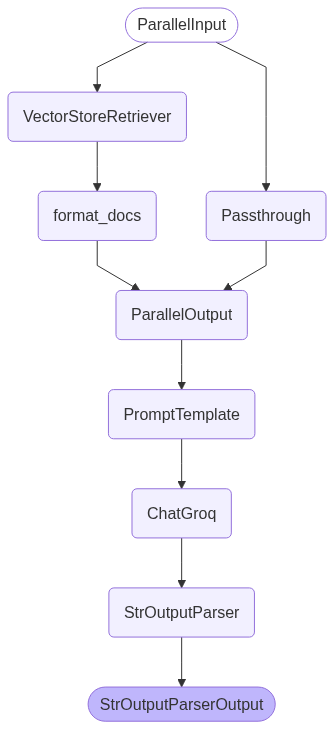

In [32]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from IPython.display import display, Image
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | rag_prompt
    | llm
    | StrOutputParser()
)


display(Image(rag_chain.get_graph().draw_mermaid_png()))

In [47]:
rag_chain.invoke("অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?")

'অনুপমের ভাষায় সুপুরুষ বলতে বোঝানো হয়েছে- তার মামা।'